In [2]:
from typing import List, Tuple
from dataclasses import dataclass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
#import gdown

In [17]:
# С помощью метода gdown.download()указываем путь к базе на Google Drive и скачиваем zip-архив в директорию Google Colab: 
#gdown.download('https://storage.googleapis.com/terra_ai/DataSets/bus.zip', None, quiet=True)
#gdown.download('https://drive.google.com/file/d/1f66U_VcTzthudVjPUQ1E8-_5yJPXsE_8/view?usp=share_link', 'copybook_train_224х224.zip', quiet=True)
#               https://drive.google.com/file/d/1uFTzwFc3tmS-D7azjMiJcxSfn71BPqKt/view?usp=sharing
#               https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip

In [10]:
!unzip -q '/content/copybook_train_224х224.zip' -d ''

In [11]:
!unzip -q '/content/copybook_test_224х224.zip' -d ''

In [2]:
@dataclass
class Config:
#    train_dir_filepath: Path = Path('/content/copybook_train_224х224')
#    test_dir_filepath: Path = Path('/content/copybook_test_224х224')
    train_dir_filepath: Path = Path('..\\data\\copybook\\copybook_train_224х224')
    test_dir_filepath: Path = Path('..\\data\\copybook\\copybook_test_224х224')
    num_classes: int = 2
    image_size: Tuple[int, int] = (224, 224)
    train_batch_size: int = 32
    test_batch_size: int = 32
    
    @classmethod
    def __get_data(cls, path):
      images_filepaths: List[str] = []
      labels: List[int] = []
      label_list = [str(x.name) for x in path.iterdir() if x.is_dir()]

      for label in label_list:
        path_current_label = path / label
        for curent_path in path_current_label.iterdir():
          images_filepaths.append(str(curent_path))
          labels.append(int(label))

      return images_filepaths, labels


    def get_train_data(self):
      return self.__get_data(self.train_dir_filepath)


    def get_test_data(self):
      return self.__get_data(self.test_dir_filepath)

In [3]:
def prepare(filepath: str, label: int) -> Tuple[tf.Tensor, tf.Tensor]:
    image_bytes = tf.io.read_file(filename=filepath)
    image = tf.io.decode_jpeg(contents=image_bytes, channels=3)  # RGB
    image = tf.image.resize(image, config.image_size, 'nearest')
    image = image / 255
    image = tf.cast(image, dtype=tf.float32)
    return image, tf.one_hot(label, depth=config.num_classes)

In [4]:
config = Config()

In [5]:
images_filepaths, labels = config.get_train_data()

In [6]:
ds = tf.data.Dataset.from_tensor_slices((images_filepaths, labels))
ds = ds.map(lambda image_filepath, label: prepare(image_filepath, label))
ds = ds.batch(batch_size=config.train_batch_size, drop_remainder=True)
ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

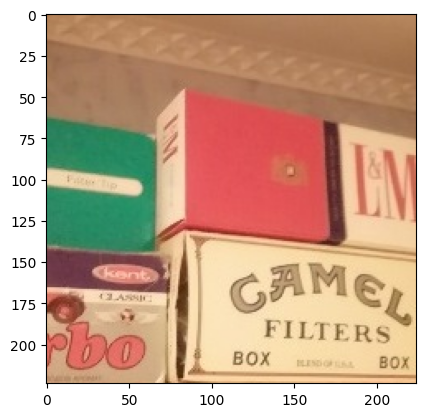

In [7]:
plt.imshow(np.array(list(ds.as_numpy_iterator())[2][0][2]))

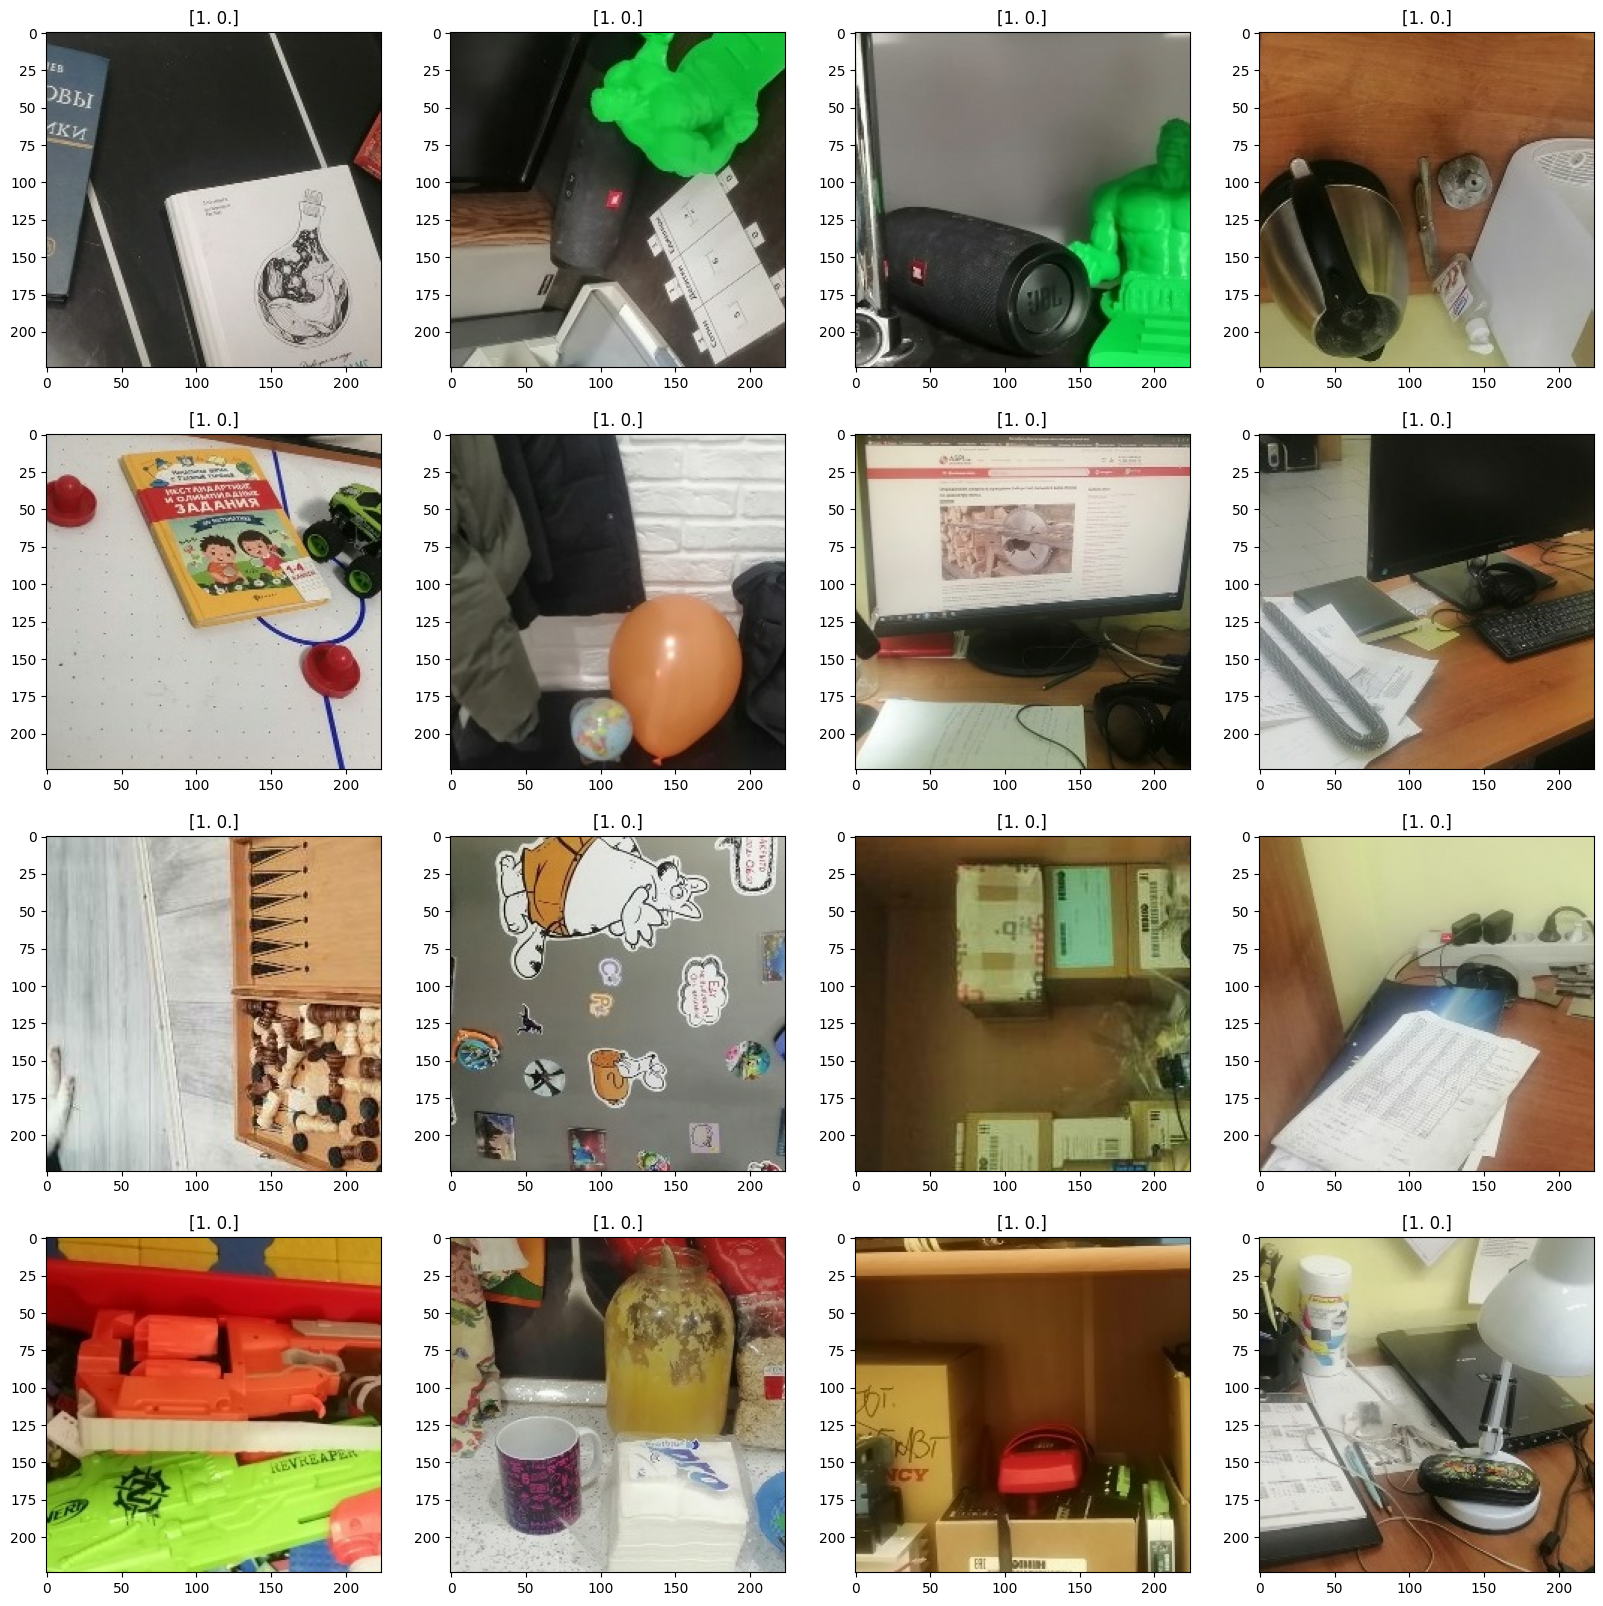

In [8]:
line = 4
column = 4
line_current = 0
column_current = 0

fig, axs = plt.subplots(line, column, figsize = (20, 20))
im_num_max = line * column

b = 0
n = 0

for batch_im, batch_label in ds:
    if column_current == column:
        break
    for im, label in zip(batch_im, batch_label):
        if column_current == column:
            break
        
        axs[line_current][column_current].imshow(im)
        axs[line_current][column_current].set_title(str(np.array(label)))
        
        line_current += 1
        if line_current == line:
            line_current = 0
            column_current += 1